# GPT-4o와 RAG를 결합하는 방법 - 의류 매치메이커 앱 만들기

의류 매치메이커 앱 주피터 노트북에 오신 것을 환영합니다! 이 프로젝트는 의류 품목의 이미지를 분석하고 색상, 스타일, 유형과 같은 주요 특징을 추출하는 데 있어 GPT-4o 모델의 강력한 성능을 보여줍니다. 저희 앱의 핵심은 OpenAI에서 개발한 이 고급 이미지 분석 모델을 사용하여 입력된 의류 품목의 특성을 정확하게 식별할 수 있습니다.

GPT-4o는 자연어 처리와 이미지 인식을 결합한 모델로, 텍스트와 시각적 입력을 모두 이해하고 응답을 생성할 수 있습니다.

GPT-4o 모델의 기능을 기반으로 사용자 지정 매칭 알고리즘과 RAG 기법을 사용하여 식별된 특징을 보완하는 항목을 지식 기반에서 검색합니다. 이 알고리즘은 색상 호환성 및 스타일 일관성과 같은 요소를 고려하여 사용자에게 적합한 추천을 제공합니다. 이 노트북을 통해 의류 추천 시스템을 만드는 데 이러한 기술을 실제로 적용하는 방법을 소개하고자 합니다.

GPT-4o + RAG(검색 증강 세대)의 조합을 사용하면 몇 가지 이점이 있습니다:

1. **문맥 이해**: GPT-4o는 입력 이미지를 분석하고 묘사된 사물, 장면, 활동 등의 맥락을 이해할 수 있습니다. 이를 통해 인테리어 디자인, 요리, 교육 등 다양한 영역에서 보다 정확하고 관련성 높은 제안이나 정보를 제공할 수 있습니다.
2. **풍부한 지식 기반**: RAG는 GPT-4의 생성 기능과 다양한 분야의 방대한 정보에 액세스하는 검색 구성 요소를 결합합니다. 즉, 이 시스템은 역사적 사실부터 과학적 개념에 이르기까지 광범위한 지식을 기반으로 제안이나 인사이트를 제공할 수 있습니다.
3. **사용자 정의**: 이 접근 방식을 사용하면 다양한 애플리케이션에서 특정 사용자 요구 사항이나 선호도에 맞게 쉽게 사용자 지정할 수 있습니다. 사용자의 예술 취향에 맞는 추천을 제공하거나 학생의 학습 수준에 따라 교육용 콘텐츠를 제공하는 등, 개인화된 경험을 제공하도록 시스템을 조정할 수 있습니다.

전반적으로 GPT-4o + RAG 접근 방식은 생성 및 검색 기반 AI 기술의 강점을 모두 활용하여 다양한 패션 관련 애플리케이션을 위한 강력하고 유연한 솔루션을 제공합니다.

### 환경 설정

먼저 필요한 종속성을 설치한 다음 라이브러리를 가져오고 나중에 사용할 몇 가지 유틸리티 함수를 작성합니다.

In [ ]:
%pip install openai --quiet
%pip install tenacity --quiet
%pip install tqdm --quiet
%pip install numpy --quiet
%pip install typing --quiet
%pip install tiktoken --quiet
%pip install concurrent --quiet

In [2]:
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List

client = OpenAI()

GPT_MODEL = "gpt-4o"
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013

### 임베딩 만들기
이제 데이터베이스를 선택하고 그에 대한 임베딩을 생성하여 지식창고를 설정하겠습니다. 이를 위해 데이터 폴더에 있는 `sample_styles.csv` 파일을 사용하고 있습니다. 이 파일은 `~44K` 항목이 포함된 더 큰 데이터 집합의 샘플입니다. 이 단계는 기본 제공 벡터 데이터베이스를 사용하는 것으로 대체할 수도 있습니다. 예를 들어, [이 쿡북](https://github.com/openai/openai-cookbook/tree/main/examples/vector_databases) 중 하나를 따라 벡터 데이터베이스를 설정할 수 있습니다.

In [3]:
styles_filepath = "data/sample_clothes/sample_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


이제 전체 데이터 세트에 대한 임베딩을 생성합니다. 이러한 임베딩의 실행을 병렬화하여 스크립트가 더 큰 데이터 세트에 맞게 확장되도록 할 수 있습니다. 이 로직을 사용하면 전체 '44K' 항목 데이터 세트에 대한 임베딩을 생성하는 시간이 약 4시간에서 약 2~3분으로 단축됩니다.

In [4]:
## Batch Embedding Logic

# Simple function to take in a list of text objects and return them as a list of embeddings
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: List):
    response = client.embeddings.create(
        input=input,
        model=EMBEDDING_MODEL
    ).data
    return [data.embedding for data in response]


# Splits an iterable into batches of size n.
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]
     

# Function for batching and parallel processing the embeddings
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base")
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        
        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(encoded_corpus, batch_size)
        ]

        with tqdm(total=len(encoded_corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings
    

# Function to generate embeddings for a given column in a DataFrame
def generate_embeddings(df, column_name):
    # Initialize an empty list to store embeddings
    descriptions = df[column_name].astype(str).tolist()
    embeddings = embed_corpus(descriptions)

    # Add the embeddings as a new column to the DataFrame
    df['embeddings'] = embeddings
    print("Embeddings created successfully.")

#### 임베딩을 생성하는 두 가지 옵션이 있습니다:
다음 줄은 샘플 의류 데이터 세트에 대한 임베딩을 **생성**합니다. 처리하는 데 약 0.02초가 걸리고 결과를 로컬 .csv 파일에 쓰는 데 약 30초가 더 걸립니다. 이 프로세스는 `$0.00013/1K` 토큰으로 가격이 책정된 `text_embedding_3_large` 모델을 사용합니다. 데이터 세트에 약 `1K` 개의 항목이 있다고 가정하면, 다음 작업의 비용은 대략 `$0.001`입니다. 44K` 항목의 전체 데이터 세트로 작업하기로 결정한 경우, 이 작업은 처리하는 데 2~3분이 걸리며 비용은 약 `$0.07`입니다.

**직접 임베딩을 생성하지 않으려는 경우**, 미리 계산된 임베딩 데이터 세트를 사용합니다. 이 셀을 건너뛰고 다음 셀의 코드를 주석 처리하여 미리 계산된 벡터 로딩을 계속 진행할 수 있습니다. 이 작업은 메모리의 모든 데이터를 로드하는 데 약 1분 정도 소요됩니다.

In [5]:
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('data/sample_clothes/sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=1000, num_tokens=8280, est_embedding_cost=0.00 USD


1024it [00:01, 724.12it/s]                         


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [6]:
# styles_df = pd.read_csv('data/sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')

# # Convert the 'embeddings' column from string representations of lists to actual lists of floats
# styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.006903026718646288, 0.0004031236458104104, ...  
1  [-0.04371623694896698, -0.008869604207575321, ...  

### 매칭 알고리즘 구축하기

이 섹션에서는 데이터 프레임에서 유사한 항목을 찾기 위한 코사인 유사도 검색 알고리즘을 개발하겠습니다. 이를 위해 사용자 정의 코사인 유사도 함수를 활용하겠습니다. 'sklearn' 라이브러리에는 코사인 유사도 함수가 내장되어 있지만, 최근 SDK가 업데이트되면서 호환성 문제가 발생하여 자체적으로 표준 코사인 유사도 계산을 구현해야 했습니다.

벡터 데이터베이스가 이미 설정되어 있다면 이 단계를 건너뛸 수 있습니다. 대부분의 표준 데이터베이스에는 자체 검색 기능이 제공되므로 이 가이드에서 설명하는 후속 단계를 간소화할 수 있습니다. 그러나 특정 임계값 또는 반환되는 특정 수의 일치 항목과 같은 특정 요구 사항을 충족하도록 매칭 알고리즘을 조정할 수 있음을 보여드리고자 합니다.

find_similar_items` 함수는 네 가지 매개변수를 허용합니다:
- 임베딩`: 일치 항목을 찾으려는 임베딩입니다.
- 임베딩`: 가장 일치하는 항목을 찾기 위해 검색할 임베딩 목록입니다.
- 임계값`(선택 사항): 이 매개변수는 일치 항목이 유효한 것으로 간주되는 최소 유사도 점수를 지정합니다. 임계값이 높을수록 더 가까운(더 나은) 일치 항목을 반환하고, 임계값이 낮을수록 초기 `임베딩`과 더 가깝게 일치하지는 않지만 더 많은 항목이 반환될 수 있습니다.
- top_k`(선택 사항): 이 매개변수는 지정된 임계값을 초과하는 반환할 항목의 수를 결정합니다. 제공된 '임베딩'에 대해 가장 높은 점수를 받은 일치 항목이 반환됩니다.

In [7]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""
    
    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]
    
    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]
    
    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

In [8]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""
   
   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()

   
   similar_items = []
   for desc in item_descs:
      
      # Generate the embedding for the input item
      input_embedding = get_embeddings([desc])
    
      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]
    
   return similar_items

### 분석 모듈

이 모듈에서는 `gpt-4o`를 활용하여 입력 이미지를 분석하고 자세한 설명, 스타일, 유형과 같은 중요한 특징을 추출합니다. 분석은 간단한 API 호출을 통해 수행되며, 분석할 이미지의 URL을 제공하고 모델에 관련 특징을 식별하도록 요청합니다.

모델이 정확한 결과를 반환하도록 하기 위해 특정 기법을 프롬프트에 사용합니다:

1. **출력 형식 사양**: 모델에 다음과 같이 구성된 사전 정의된 구조의 JSON 블록을 반환하도록 지시합니다:
   - 항목` (str[]): 스타일, 색상, 성별 등 의류 품목에 대한 간결한 제목을 나타내는 문자열 목록입니다. 이러한 제목은 원래 데이터베이스의 `productDisplayName` 속성과 매우 유사합니다.
   - 카테고리`(str): 주어진 항목을 가장 잘 나타내는 카테고리입니다. 모델은 원본 스타일 데이터 프레임에 있는 모든 고유한 '기사 유형' 목록에서 선택합니다.
   - 성별` (str): 항목의 성별을 나타내는 레이블입니다. 모델은 `[남성, 여성, 소년, 소녀, 유니섹스]` 옵션 중에서 선택합니다.

2. **명확하고 간결한 지침**:
   - 항목 제목에 포함되어야 하는 내용과 출력 형식에 대한 명확한 지침을 제공합니다. 출력은 JSON 형식이어야 하지만 모델 응답에 일반적으로 포함되는 `json` 태그가 없어야 합니다.

3. **원샷 예제**:
   - 예상 출력을 더욱 명확히 하기 위해 모델에 예제 입력 설명과 그에 해당하는 예제 출력을 제공합니다. 이렇게 하면 사용되는 토큰 수와 통화 비용이 증가할 수 있지만, 모델을 안내하는 데 도움이 되며 전반적인 성능이 향상됩니다.

이러한 구조화된 접근 방식을 통해 'gpt-4o' 모델로부터 정확하고 유용한 정보를 얻어 추가 분석 및 데이터베이스 통합을 목표로 합니다.

In [9]:
def analyze_image(image_base64, subcategories):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender". 
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           The category needs to be chosen between the types in this list: {subcategories}.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.
                           
                           Example Input: An image representing a black leather jacket.

                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

### 샘플 이미지로 프롬프트 테스트하기

프롬프트의 효과를 평가하기 위해 데이터 세트에서 선택한 이미지를 로드하고 테스트해 보겠습니다. 다양한 스타일, 성별 및 유형을 보장하기 위해 `"data/sample_clothes/sample_images"` 폴더의 이미지를 사용하겠습니다. 선택한 샘플은 다음과 같습니다:

- 2133.jpg`: 남성 셔츠
- 7143.jpg`: 여성 셔츠
- `4226.jpg`: 캐주얼 남성 프린트 티셔츠

이러한 다양한 이미지로 프롬프트를 테스트함으로써 다양한 유형의 의류 품목과 액세서리에서 관련 특징을 정확하게 분석하고 추출하는 능력을 평가할 수 있습니다.

.jpg 이미지를 base64로 인코딩하는 유틸리티 함수가 필요합니다.

In [10]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

In [11]:
# Set the path to the images and select a test image
image_path = "data/sample_clothes/sample_images/"
test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]

# Encode the test image to base64
reference_image = image_path + test_images[0]
encoded_image = encode_image_to_base64(reference_image)

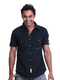

{'items': ["Slim Fit Blue Men's Jeans", "White Men's Sneakers", "Men's Silver Watch"], 'category': 'Shirts', 'gender': 'Men'}


In [12]:
# Select the unique subcategories from the DataFrame
unique_subcategories = styles_df['articleType'].unique()

# Analyze the image and return the results
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

# Display the image and the analysis results
display(Image(filename=reference_image))
print(image_analysis)

다음으로 이미지 분석의 출력을 처리하고 이를 사용하여 데이터 세트에서 일치하는 항목을 필터링하고 표시합니다. 다음은 코드의 분석입니다:

1. **이미지 분석 결과 추출하기**: 'image_analysis' 사전에서 항목 설명, 카테고리, 성별을 추출합니다.

2. **데이터 세트 필터링하기**: 이미지 분석 결과의 성별과 일치하는(또는 유니섹스인) 항목만 포함하고 분석 이미지와 같은 카테고리의 항목은 제외하도록 `styles_df` 데이터 프레임을 필터링합니다.

3. **일치하는 항목 찾기**: 필터링된 데이터셋에서 분석 이미지에서 추출한 설명과 일치하는 항목을 찾기 위해 `find_matching_items_with_rag` 함수를 사용합니다.

4. **일치하는 항목 표시하기**: 일치하는 항목의 이미지를 표시하기 위한 HTML 문자열을 생성합니다. 항목 ID를 사용하여 이미지 경로를 구성하고 각 이미지를 HTML 문자열에 추가합니다. 마지막으로 `display(HTML(html))`을 사용해 노트북에 이미지를 렌더링합니다.

이 셀은 이미지 분석 결과를 사용해 데이터 세트를 필터링하고 분석된 이미지의 특성과 일치하는 항목을 시각적으로 표시하는 방법을 효과적으로 보여줍니다.

In [13]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)

# Display the matching items (this will display 2 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']
        
    # Path to the image file
    image_path = f'data/sample_clothes/sample_images/{item_id}.jpg'
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
# Display the image
display(HTML(html))

513 Remaining Items
["Slim Fit Blue Men's Jeans", "White Men's Sneakers", "Men's Silver Watch"]


### 가드레일

GPT-4o와 같은 대규모 언어 모델(LLM)을 사용할 때 '가드레일'은 모델의 출력이 원하는 파라미터 또는 경계 내에서 유지되도록 하기 위해 마련된 메커니즘 또는 점검을 의미합니다. 이러한 가드레일은 특히 복잡하거나 미묘한 작업을 처리할 때 모델 응답의 품질과 관련성을 유지하는 데 매우 중요합니다.

가드레일은 여러 가지 이유로 유용합니다:

1. **정확성**: 모델의 출력이 정확하고 제공된 입력과 관련이 있는지 확인하는 데 도움이 됩니다.
2. **일관성**: 특히 유사하거나 관련된 입력을 처리할 때 모델 응답의 일관성을 유지합니다.
3. **안전**: 모델이 유해하거나 불쾌하거나 부적절한 콘텐츠를 생성하지 못하도록 방지합니다.
4. **문맥 관련성**: 모델의 결과물이 사용 중인 특정 작업 또는 도메인과 문맥적으로 관련이 있는지 확인합니다.

저희의 경우, 패션 이미지를 분석하고 원래 의상을 보완할 수 있는 아이템을 제안하는 데 GPT-4o를 사용하고 있습니다. 가드레일을 구현하기 위해 **결과를 구체화**할 수 있습니다: GPT-4o로부터 초기 제안을 받은 후, 원본 이미지와 제안된 아이템을 모델에게 다시 전송할 수 있습니다. 그런 다음 GPT-4o에게 제안된 각 아이템이 실제로 원래 의상과 잘 어울리는지 평가하도록 요청할 수 있습니다.

이렇게 하면 모델이 피드백이나 추가 정보를 기반으로 자체적으로 수정하고 출력을 조정할 수 있습니다. 이러한 가드레일을 구현하고 자체 수정 기능을 활성화함으로써 패션 분석 및 추천의 맥락에서 모델 출력의 신뢰성과 유용성을 향상시킬 수 있습니다.

이를 위해 추천된 아이템이 원래 의상과 일치하는지 여부에 대한 질문에 "예" 또는 "아니오"라는 간단한 대답을 묻는 프롬프트를 작성합니다. 이러한 이분법적 응답은 개선 프로세스를 간소화하고 모델의 명확하고 실행 가능한 피드백을 보장하는 데 도움이 됩니다.

In [14]:
def check_match(reference_image_base64, suggested_image_base64):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """ You will be given two images of two different items of clothing.
                            Your goal is to decide if the items in the images would work in an outfit together.
                            The first image is the reference item (the item that the user is trying to match with another item).
                            You need to decide if the second item would work well with the reference item.
                            Your response must be a JSON output with the following fields: "answer", "reason".
                            The "answer" field must be either "yes" or "no", depending on whether you think the items would work well together.
                            The "reason" field must be a short explanation of your reasoning for your decision. Do not include the descriptions of the 2 images.
                            Do not include the ```json ``` tag in the output.
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{reference_image_base64}",
                },
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{suggested_image_base64}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

마지막으로 위에서 확인된 아이템 중 어떤 아이템이 의상을 진정으로 보완하는지 알아봅시다.

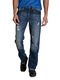

The items match!
The black shirt and blue jeans create a classic and casual outfit that works well together.


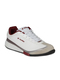

The items match!
The black shirt and the white sneakers with red and beige accents can work well together. Black is a versatile color that pairs well with many shoe options, and the white sneakers can add a sporty and casual touch to the outfit.


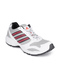

The items match!
The black button-up shirt is casual and versatile, making it compatible with the white and red athletic shoes for a relaxed and sporty look.


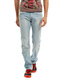

The items match!
The black shirt pairs well with the light blue jeans, creating a classic and balanced color combination that is casual and stylish.


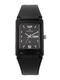

The items match!
Both the black shirt and the black watch have a sleek and coordinated look, making them suitable to be worn together as part of an outfit.


In [15]:
# Select the unique paths for the generated images
paths = list(set(paths))

for path in paths:
    # Encode the test image to base64
    suggested_image = encode_image_to_base64(path)
    
    # Check if the items match
    match = json.loads(check_match(encoded_image, suggested_image))
    
    # Display the image and the analysis results
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match["reason"])

초기 잠재적 아이템 목록이 더욱 세분화되어 의상과 잘 어울리는 엄선된 선택이 이루어지는 것을 관찰할 수 있습니다. 또한 이 모델은 각 아이템이 잘 어울리는 것으로 간주되는 이유에 대한 설명을 제공하여 의사 결정 과정에 대한 귀중한 통찰력을 제공합니다.

결론 ### 결론

이번 주피터 노트북에서는 패션 분야에 GPT-4o 및 기타 머신러닝 기법을 적용하는 방법을 살펴봤습니다. 의류 아이템의 이미지를 분석하고, 관련 특징을 추출하고, 이 정보를 사용하여 원래 의상을 보완하는 어울리는 아이템을 찾는 방법을 시연했습니다. 가드레일과 자체 수정 메커니즘을 구현하여 모델의 제안이 정확하고 맥락과 관련성이 있도록 개선했습니다.

이 접근 방식은 실제 세계에서 다음과 같은 몇 가지 실용적인 용도로 사용됩니다:

1. **개인화된 쇼핑 도우미**: 소매업체는 이 기술을 사용하여 고객에게 개인화된 의상을 추천함으로써 쇼핑 경험을 개선하고 고객 만족도를 높일 수 있습니다.
2. **가상 옷장 애플리케이션**: 사용자는 자신의 의류 아이템 이미지를 업로드하여 가상 옷장을 만들고 기존 아이템과 어울리는 새로운 아이템을 제안받을 수 있습니다.
3. **패션 디자인 및 스타일링**: 패션 디자이너와 스타일리스트는 이 도구를 사용하여 다양한 조합과 스타일을 실험함으로써 창작 과정을 간소화할 수 있습니다.

하지만 고려해야 할 사항 중 하나는 **비용**입니다. LLM과 이미지 분석 모델을 사용하면 특히 광범위하게 사용할 경우 비용이 발생할 수 있습니다. 이러한 기술을 구현할 때 비용 효율성을 고려하는 것이 중요합니다.

전반적으로 이 노트북은 패션과 AI의 교차점에 대한 추가 탐색과 개발의 토대가 되어 더욱 개인화되고 지능적인 패션 추천 시스템의 문을 열어줄 것입니다.